TODO:

- calculate accuracy
- cross validation
- plots
- epa model creation
- cp model creation
- xyac model creation
- dropback model creation
- non-vegas wp model creation
- elo power ranking model
- weighted epa model
- dvoa ranking model
- implied probability
- expected value

In [38]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

# imported_data = nfl.import_pbp_data(list(range(1999, 2024)))
imported_data = nfl.import_pbp_data([2022])
pbp_data = imported_data.copy()

pbp_data.head()

2022 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,,,0,0,NaN,NaN,None,None,None,None
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11,11,NaN,NaN,None,None,None,None
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,NaN,NaN,None,None,None,None
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,0.56,3.07,True,ANGLE,ZONE_COVERAGE,COVER_2
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,NaN,NaN,None,None,None,None


In [33]:
pbp_data.loc[3477, 'qtr'] in [1,2] and pbp_data.loc[3578, 'qtr'] in [3,4,5] or pbp_data.loc[3477, 'qtr'] in [1,2] and pbp_data.loc[3578, 'qtr'] in [3,4,5]

True

In [39]:
import pandas as pd

def find_game_next_score_half(pbp_dataset):
    # Which rows are the scoring plays
    score_plays = pbp_dataset.index[(pbp_dataset['sp'] == 1) & (pbp_dataset['play_type'] != "no_play")].tolist()

    def find_next_score(play_i, score_plays_i, pbp_df):
        # game_id = pbp_df.iloc[0]['game_id']
        # df_len = len(pbp_df)
        # print(f"{game_id}: Play {play_i} of {len(pbp_df)} Status: Beginning")
        # Find the next score index for the current play
        next_scores = [i for i in score_plays_i if i >= play_i]
        # print(f"{game_id}: Play {play_i} of {df_len}: Next Scores: {next_scores} Status: Phase 1")
        next_score_i = next_scores[0] if next_scores else None
        # print(f"{game_id}: Play {play_i} of {df_len}: Next Score Index: {next_score_i} Status: Phase 2")
        # next_score_i_qtr = pbp_df.loc[next_score_i, 'qtr'] if next_score_i else None
        # print(f"{game_id}: Play {play_i} of {df_len}: Next Score Qtr: {next_score_i_qtr} Status: Phase 3")

        if next_score_i is None or \
           (pbp_df.loc[play_i, 'qtr'] in [1, 2] and pbp_df.loc[next_score_i, 'qtr'] in [3, 4, 5]) or \
           (pbp_df.loc[play_i, 'qtr'] in [3, 4] and pbp_df.loc[next_score_i, 'qtr'] == 5):
            score_type = "No_Score"
            # print(f"{game_id}: Play {play_i} of {df_len}: Score Type: {score_type}, Status: Phase 4")
            score_drive = pbp_df.loc[play_i, 'drive']
            # print(f"{game_id}: Play {play_i} of {df_len}: Score Drive: {score_drive} Status: Phase 5")
        else:
            score_drive = pbp_df.loc[next_score_i, 'drive']
            # print(f"{game_id}: Play {play_i} of {df_len}: Score Drive: {score_drive} Status: Phase 6")
            
            if pbp_df.loc[next_score_i, 'touchdown'] == 1 and (pbp_df.loc[next_score_i, 'td_team'] != pbp_df.loc[next_score_i, 'posteam']):
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Opp_Touchdown"
                else:
                    score_type = "Touchdown"
            elif pbp_df.loc[next_score_i, 'field_goal_result'] == "made":
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Field_Goal"
                else:
                    score_type = "Opp_Field_Goal"
            elif pbp_df.loc[next_score_i, 'touchdown'] == 1:
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Touchdown"
                else:
                    score_type = "Opp_Touchdown"
            elif pbp_df.loc[next_score_i, 'safety'] == 1:
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Opp_Safety"
                else:
                    score_type = "Safety"
            elif pbp_df.loc[next_score_i, 'extra_point_result'] == "good":
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Extra_Point"
                else:
                    score_type = "Opp_Extra_Point"
            elif pbp_df.loc[next_score_i, 'two_point_conv_result'] == "success":
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Two_Point_Conversion"
                else:
                    score_type = "Opp_Two_Point_Conversion"
            elif pbp_df.loc[next_score_i, 'defensive_two_point_conv'] == 1:
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Opp_Defensive_Two_Point"
                else:
                    score_type = "Defensive_Two_Point"
            else:
                score_type = None
        # print(f"{pbp_df.iloc[0]['game_id']}: Play {play_i} of {len(pbp_df)}: Score Type: {score_type} Status: Completed")
        return pd.DataFrame({'Next_Score_Half': [score_type], 'Drive_Score_Half': [score_drive]}, index=[play_i])

    # Applying the helper function to each row of the dataset
    next_score_data = [find_next_score(i, score_plays, pbp_dataset) for i in pbp_dataset.index]
    return pd.concat(next_score_data)

In [42]:
from multiprocessing import Pool

# unique_game_ids = pbp_data['game_id'].unique()
# 
# def get_regular_season_games(df):
#     return df.loc[df['season_type'] == 'REG']
# 
# def determine_winner(df):
#     df['Winner'] = pd.NA
#     df.loc[df['home_score'] > df['away_score'], 'Winner'] = df['home_team']
#     df.loc[df['home_score'] < df['away_score'], 'Winner'] = df['away_team']
#     df.loc[df['home_score'] == df['away_score'], 'Winner'] = "TIE"
#     return df
# 
# def get_game_df_by_game_id(df, game_id):
#     return df.loc[df['game_id'] == game_id]
# 
# with Pool(8) as p:
#     game_dataframes = p.map(get_game_df_by_game_id,[[pbp_data, game_id] for game_id in unique_game_ids])
#     reg_pbp_dataframes = p.map(get_regular_season_games, game_dataframes)
#     reg_pbp_dataframes = p.map(determine_winner, reg_pbp_dataframes)
#     pbp_next_score_half_dataframes = p.map(find_game_next_score_half, reg_pbp_dataframes)
#     pbp_next_score_half = pd.concat(pbp_next_score_half_dataframes, ignore_index=True)
#     reg_pbp_data = pd.concat(reg_pbp_dataframes, ignore_index=True)
#     reg_pbp_data = pd.concat([reg_pbp_data, pbp_next_score_half], axis=1)

reg_pbp_data = pbp_data.copy()
# Filtering for regular season games
reg_pbp_data = reg_pbp_data.loc[reg_pbp_data['season_type'] == 'REG']

# Determining the winner of each game
reg_pbp_data['Winner'] = np.where(reg_pbp_data['home_score'] > reg_pbp_data['away_score'],
                            reg_pbp_data['home_team'],
                            np.where(reg_pbp_data['home_score'] < reg_pbp_data['away_score'], reg_pbp_data['away_team'], "TIE"))
# reg_pbp_data['Winner'] = pd.NA
# reg_pbp_data.loc[reg_pbp_data['home_score'] > reg_pbp_data['away_score'], 'Winner'] = reg_pbp_data['home_team']
# reg_pbp_data.loc[reg_pbp_data['home_score'] < reg_pbp_data['away_score'], 'Winner'] = reg_pbp_data['away_team']
# reg_pbp_data.loc[reg_pbp_data['home_score'] == reg_pbp_data['away_score'], 'Winner'] = "TIE"

# Get next score half using the previously defined function
unique_game_ids = reg_pbp_data['game_id'].unique()
pbp_next_score_half = pd.concat([find_game_next_score_half(reg_pbp_data[reg_pbp_data['game_id'] == game_id]) for game_id in unique_game_ids], ignore_index=True)

# Bind to original DataFrame
reg_pbp_data = pd.concat([reg_pbp_data, pbp_next_score_half], axis=1)

# Apply filters for estimating the models
filtered_pbp_data = reg_pbp_data[
    (reg_pbp_data['Next_Score_Half'].isin(["Opp_Field_Goal", "Opp_Safety", "Opp_Touchdown", 
                                       "Field_Goal", "No_Score", "Safety", "Touchdown"])) &
    (reg_pbp_data['play_type'].isin(["field_goal", "no_play", "pass", "punt", "run", "qb_spike"])) &
    (reg_pbp_data['two_point_conv_result'].isna()) &
    (reg_pbp_data['extra_point_result'].isna()) &
    (reg_pbp_data['down'].notna()) &
    (reg_pbp_data['game_seconds_remaining'].notna())
]

# Selecting specific columns to keep file size manageable
selected_columns = [
    'game_id', 'Next_Score_Half', 'Drive_Score_Half', 'play_type', 'game_seconds_remaining', 
    'half_seconds_remaining', 'yardline_100', 'roof', 'posteam', 'defteam', 'home_team', 'ydstogo', 
    'season', 'qtr', 'down', 'week', 'drive', 'ep', 'score_differential', 'posteam_timeouts_remaining', 
    'defteam_timeouts_remaining', 'desc', 'receiver_player_name', 'pass_location', 'air_yards', 
    'yards_after_catch', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 
    'extra_point_result', 'field_goal_result', 'sp', 'Winner', 'spread_line', 'total_line'
]
filtered_pbp_data = filtered_pbp_data[selected_columns]

# Displaying the first few rows of the filtered dataset
filtered_pbp_data.head()

,game_id,Next_Score_Half,Drive_Score_Half,play_type,game_seconds_remaining,half_seconds_remaining,yardline_100,roof,posteam,defteam,...,complete_pass,incomplete_pass,interception,qb_hit,extra_point_result,field_goal_result,sp,Winner,spread_line,total_line
2,2022_01_BAL_NYJ,Opp_Field_Goal,6.0,run,3596.0,1796.0,78.0,outdoors,NYJ,BAL,...,0.0,0.0,0.0,0.0,None,None,0.0,BAL,-6.5,44.0
3,2022_01_BAL_NYJ,Opp_Field_Goal,6.0,pass,3569.0,1769.0,59.0,outdoors,NYJ,BAL,...,0.0,1.0,0.0,0.0,None,None,0.0,BAL,-6.5,44.0
4,2022_01_BAL_NYJ,Opp_Field_Goal,6.0,run,3565.0,1765.0,59.0,outdoors,NYJ,BAL,...,0.0,0.0,0.0,0.0,None,None,0.0,BAL,-6.5,44.0
5,2022_01_BAL_NYJ,Opp_Field_Goal,6.0,pass,3541.0,1741.0,54.0,outdoors,NYJ,BAL,...,0.0,1.0,0.0,1.0,None,None,0.0,BAL,-6.5,44.0
6,2022_01_BAL_NYJ,Opp_Field_Goal,6.0,punt,3533.0,1733.0,64.0,outdoors,NYJ,BAL,...,0.0,0.0,0.0,0.0,None,None,0.0,BAL,-6.5,44.0


In [14]:
def make_model_mutations(pbp):
    pbp['era0'] = np.where(pbp['season'] <= 2001, 1, 0)
    pbp['era1'] = np.where((pbp['season'] > 2001) & (pbp['season'] <= 2005), 1, 0)
    pbp['era2'] = np.where((pbp['season'] > 2005) & (pbp['season'] <= 2013), 1, 0)
    pbp['era3'] = np.where((pbp['season'] > 2013) & (pbp['season'] <= 2017), 1, 0)
    pbp['era4'] = np.where(pbp['season'] > 2017, 1, 0)

    pbp['era'] = np.select([
        pbp['era0'] == 1,
        pbp['era1'] == 1,
        pbp['era2'] == 1,
        (pbp['era3'] == 1) | (pbp['era4'] == 1)
    ], [
        0,
        1,
        2,
        3
    ])

    pbp['era'] = pd.Categorical(pbp['era'])

    pbp['down1'] = np.where(pbp['down'] == 1, 1, 0)
    pbp['down2'] = np.where(pbp['down'] == 2, 1, 0)
    pbp['down3'] = np.where(pbp['down'] == 3, 1, 0)
    pbp['down4'] = np.where(pbp['down'] == 4, 1, 0)

    pbp['home'] = np.where(pbp['posteam'] == pbp['home_team'], 1, 0)

    pbp['model_roof'] = np.where((pbp['roof'].isna()) | (pbp['roof'] == 'open') | (pbp['roof'] == 'closed'),
                                 'retractable', pbp['roof'])
    pbp['model_roof'] = pd.Categorical(pbp['model_roof'])

    pbp['retractable'] = np.where(pbp['model_roof'] == 'retractable', 1, 0)
    pbp['dome'] = np.where(pbp['model_roof'] == 'dome', 1, 0)
    pbp['outdoors'] = np.where(pbp['model_roof'] == 'outdoors', 1, 0)

    return pbp

cal_data_df = make_model_mutations(filtered_pbp_data)
cal_data_df.head()

,game_id,Next_Score_Half,Drive_Score_Half,play_type,game_seconds_remaining,half_seconds_remaining,yardline_100,roof,posteam,defteam,...,era,down1,down2,down3,down4,home,model_roof,retractable,dome,outdoors
1,1999_01_ARI_PHI,Touchdown,3.0,pass,3600.0,1800.0,77.0,outdoors,PHI,ARI,...,0,1,0,0,0,1,outdoors,0,0,1
2,1999_01_ARI_PHI,Touchdown,3.0,run,3600.0,1800.0,77.0,outdoors,PHI,ARI,...,0,0,1,0,0,1,outdoors,0,0,1
3,1999_01_ARI_PHI,Touchdown,3.0,no_play,3600.0,1800.0,76.0,outdoors,PHI,ARI,...,0,0,0,1,0,1,outdoors,0,0,1
4,1999_01_ARI_PHI,Touchdown,3.0,pass,3600.0,1800.0,81.0,outdoors,PHI,ARI,...,0,0,0,1,0,1,outdoors,0,0,1
5,1999_01_ARI_PHI,Touchdown,3.0,punt,3600.0,1800.0,71.0,outdoors,PHI,ARI,...,0,0,0,0,1,1,outdoors,0,0,1


In [18]:
# Define label mapping
label_mapping = {
    "Touchdown": 0,
    "Opp_Touchdown": 1,
    "Field_Goal": 2,
    "Opp_Field_Goal": 3,
    "Safety": 4,
    "Opp_Safety": 5,
    "No_Score": 6
}

# Apply label mapping
cal_data_df['label'] = cal_data_df['Next_Score_Half'].map(label_mapping)
cal_data_df['label'] = pd.factorize(cal_data_df['label'])[0]

# Use nflscrapR weights
cal_data_df['Drive_Score_Dist'] = cal_data_df['Drive_Score_Half'] - cal_data_df['drive']
cal_data_df['Drive_Score_Dist_W'] = (cal_data_df['Drive_Score_Dist'].max() - cal_data_df['Drive_Score_Dist']) / (
        cal_data_df['Drive_Score_Dist'].max() - cal_data_df['Drive_Score_Dist'].min())
cal_data_df['ScoreDiff_W'] = (cal_data_df['score_differential'].dropna().abs().max() - cal_data_df[
    'score_differential'].dropna().abs()) / (
                                     cal_data_df['score_differential'].dropna().abs().max() - cal_data_df[
                                 'score_differential'].dropna().abs().min())
cal_data_df['Total_W'] = cal_data_df['Drive_Score_Dist_W'] + cal_data_df['ScoreDiff_W']
cal_data_df['Total_W_Scaled'] = (cal_data_df['Total_W'] - cal_data_df['Total_W'].dropna().min()) / (
        cal_data_df['Total_W'].dropna().max() - cal_data_df['Total_W'].dropna().min())
cal_data_df['Total_W_Scaled'] = cal_data_df['Total_W_Scaled'].fillna(0)

# Filter and select columns
model_data = cal_data_df.dropna(subset=['defteam_timeouts_remaining', 'posteam_timeouts_remaining', 'yardline_100'])
model_data = model_data[
    ['label', 'season', 'half_seconds_remaining', 'yardline_100', 'home', 'retractable', 'dome', 'outdoors', 'ydstogo',
     'era0', 'era1', 'era2', 'era3', 'era4', 'down1', 'down2', 'down3', 'down4', 'posteam_timeouts_remaining',
     'defteam_timeouts_remaining', 'Total_W_Scaled']]

# Modify label
# model_data['label'] = model_data['label'].astype('int64') + 1

# Get unique seasons
seasons = model_data['season'].unique()
model_data.head()

,label,season,half_seconds_remaining,yardline_100,home,retractable,dome,outdoors,ydstogo,era0,...,era2,era3,era4,down1,down2,down3,down4,posteam_timeouts_remaining,defteam_timeouts_remaining,Total_W_Scaled
1,0,1999.0,1800.0,77.0,1,0,0,1,10.0,1,...,0,0,0,1,0,0,0,3.0,3.0,0.642646
2,0,1999.0,1800.0,77.0,1,0,0,1,10.0,1,...,0,0,0,0,1,0,0,3.0,3.0,0.642646
3,0,1999.0,1800.0,76.0,1,0,0,1,9.0,1,...,0,0,0,0,0,1,0,3.0,3.0,0.642646
4,0,1999.0,1800.0,81.0,1,0,0,1,14.0,1,...,0,0,0,0,0,1,0,3.0,3.0,0.642646
5,0,1999.0,1800.0,71.0,1,0,0,1,4.0,1,...,0,0,0,0,0,0,1,3.0,3.0,0.642646


In [19]:
model_data['label'].value_counts()

label
0    270414
2    205847
4    146651
1    145224
3    100826
6      2770
5      2249
Name: count, dtype: int64

In [21]:
import xgboost as xgb

nrounds = 525
params = {
    "booster": "gbtree",
    'device': 'cuda',
    "objective": "multi:softprob",
    'sampling_method': 'gradient_based',
    'tree_method': 'approx',
    "eval_metric": ["auc", "merror", "mlogloss"],
    "num_class": 7,
    "eta": 0.025,
    "gamma": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "max_depth": 5,
    "min_child_weight": 1
    # "multi_strategy": "multi_output_tree"
}

xgb_model = xgb.XGBClassifier(
    booster=params["booster"],
    objective=params["objective"],
    eval_metric=params["eval_metric"],
    num_class=params["num_class"],
    eta=params["eta"],
    gamma=params["gamma"],
    subsample=params["subsample"],
    colsample_bytree=params["colsample_bytree"],
    max_depth=params["max_depth"],
    min_child_weight=params["min_child_weight"],
    n_estimators=nrounds
)

In [23]:
# do all at once
# change to xgbclassifier
# add train test split
# clean up repository
# backtesting
# - accuracy
# - calibration
# - cross validation
# - plots
# - brier score
# investigate implied probability
# investigate rolling epa
# investigate weighted epa

cv_results = pd.DataFrame()

for x in seasons:
    test_data = model_data[model_data['season'] == x].drop(columns=['season'])
    train_data = model_data[model_data['season'] != x].drop(columns=['season'])

    full_train = xgb.DMatrix(data=train_data.drop(columns=['label', 'Total_W_Scaled']), label=train_data['label'],
                             weight=train_data['Total_W_Scaled'])
    dtest = xgb.DMatrix(data=test_data.drop(columns=['label', 'Total_W_Scaled']), label=test_data['label'],
                         weight=test_data['Total_W_Scaled'])
    ep_model = xgb.train(params=params, 
                         dtrain=full_train, 
                         num_boost_round=nrounds, 
                         evals=[(full_train, 'train'), (dtest, 'test')],
                         verbose_eval=200)

    preds = pd.DataFrame(ep_model.predict(xgb.DMatrix(test_data.drop(columns=['label', 'Total_W_Scaled']))))
    preds.columns = ["Touchdown", "Opp_Touchdown", "Field_Goal", "Opp_Field_Goal", "Safety", "Opp_Safety", "No_Score"]

    cv_data = pd.concat([test_data.reset_index(drop=True), preds], axis=1)
    cv_data['season'] = x
    cv_results = pd.concat([cv_results, cv_data], ignore_index=True)

cv_results

# Define your calibration plot logic here using pandas operations
# Please make sure to map label values to their corresponding outcome names as shown in the R code.
# For the plotting part, you can use libraries like Matplotlib or Seaborn.
# The details of your specific plotting needs are not provided in the code snippet you shared.

# Example: Calibration plot using Seaborn

# plot_data = cv_results[
#     ['Touchdown', 'Opp_Touchdown', 'Field_Goal', 'Opp_Field_Goal', 'Safety', 'Opp_Safety', 'No_Score', 'label']]
# plot_data = pd.melt(plot_data, id_vars=['label'], var_name='type', value_name='pred_prob')

# Continue with the binning and calibration plot logic here using pandas and libraries like Seaborn or Matplotlib.

[0]	train-auc:0.51922	train-merror:0.68538	train-mlogloss:1.93777	test-auc:0.46631	test-merror:0.69905	test-mlogloss:1.93807
[200]	train-auc:0.53419	train-merror:0.68526	train-mlogloss:1.58544	test-auc:0.51149	test-merror:0.69957	test-mlogloss:1.59649
[400]	train-auc:0.53590	train-merror:0.68522	train-mlogloss:1.57403	test-auc:0.50976	test-merror:0.69957	test-mlogloss:1.58957
[524]	train-auc:0.53619	train-merror:0.68521	train-mlogloss:1.57373	test-auc:0.50997	test-merror:0.69957	test-mlogloss:1.58998
[0]	train-auc:0.52569	train-merror:0.68510	train-mlogloss:1.93770	test-auc:0.50395	test-merror:0.70278	test-mlogloss:1.93780
[200]	train-auc:0.54270	train-merror:0.68218	train-mlogloss:1.58084	test-auc:0.50170	test-merror:0.71230	test-mlogloss:1.61491
[400]	train-auc:0.54425	train-merror:0.68210	train-mlogloss:1.56937	test-auc:0.50164	test-merror:0.71249	test-mlogloss:1.60473
[524]	train-auc:0.54454	train-merror:0.68205	train-mlogloss:1.56902	test-auc:0.50165	test-merror:0.71258	test-mlogl

,label,half_seconds_remaining,yardline_100,home,retractable,dome,outdoors,ydstogo,era0,era1,...,defteam_timeouts_remaining,Total_W_Scaled,Touchdown,Opp_Touchdown,Field_Goal,Opp_Field_Goal,Safety,Opp_Safety,No_Score,season
0,0,1800.0,77.0,1,0,0,1,10.0,1,0,...,3.0,0.642646,0.294478,0.159042,0.234912,0.113834,0.192254,0.002504,0.002976,1999.0
1,0,1800.0,77.0,1,0,0,1,10.0,1,0,...,3.0,0.642646,0.294500,0.159154,0.235000,0.113600,0.192268,0.002504,0.002976,1999.0
2,0,1800.0,76.0,1,0,0,1,9.0,1,0,...,3.0,0.642646,0.291577,0.157271,0.232726,0.112260,0.200744,0.002478,0.002945,1999.0
3,0,1800.0,81.0,1,0,0,1,14.0,1,0,...,3.0,0.642646,0.297637,0.160769,0.232400,0.111566,0.192890,0.002503,0.002234,1999.0
4,0,1800.0,71.0,1,0,0,1,4.0,1,0,...,3.0,0.642646,0.292734,0.154750,0.237610,0.109745,0.199737,0.002493,0.002931,1999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873976,4,243.0,90.0,1,0,1,0,10.0,0,0,...,1.0,0.481752,0.320064,0.165508,0.231882,0.112349,0.163873,0.002502,0.003821,2022.0
873977,4,240.0,90.0,1,0,1,0,10.0,0,0,...,1.0,0.481752,0.316872,0.166523,0.233029,0.112538,0.164684,0.002515,0.003840,2022.0
873978,4,205.0,84.0,1,0,1,0,4.0,0,0,...,1.0,0.481752,0.329281,0.163529,0.232362,0.106065,0.162038,0.002793,0.003931,2022.0
873979,4,167.0,74.0,1,0,1,0,10.0,0,0,...,1.0,0.472589,0.323276,0.163710,0.236594,0.107345,0.163293,0.002138,0.003645,2022.0


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

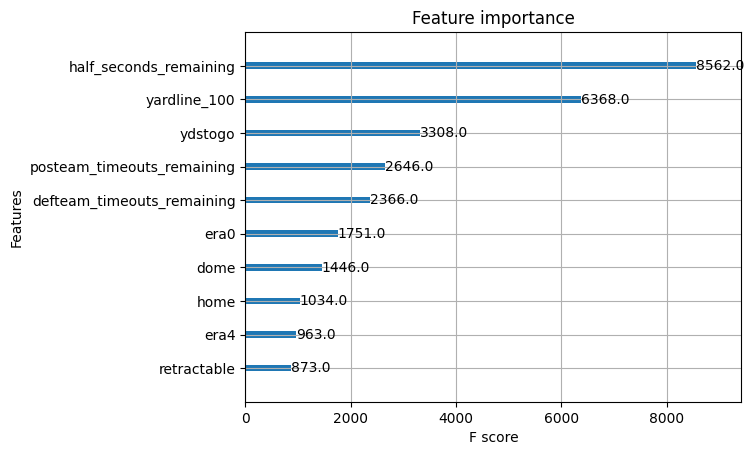

In [24]:
xgb.plot_importance(ep_model, max_num_features=10)

In [91]:
# Selecting specific columns
selected_columns = ['Touchdown', 'Opp_Touchdown', 'Field_Goal', 'Opp_Field_Goal', 'Safety', 'Opp_Safety', 'No_Score', 'label']
cv_selected = cv_results[selected_columns]

# Pivoting the data to a long format
plot = cv_selected.melt(id_vars='label', var_name='type', value_name='pred_prob')

# Binning predicted probabilities
plot['bin_pred_prob'] = (plot['pred_prob'] / 0.05).round() * 0.05

# Creating the 'outcome' column
outcome_map = {
    0: "Touchdown",
    1: "Opp_Touchdown",
    2: "Field_Goal",
    3: "Opp_Field_Goal",
    4: "Safety",
    5: "Opp_Safety",
    6: "No_Score"
}
plot['outcome'] = plot['label'].map(outcome_map)

# Grouping and calculating the actual probability
grouped = plot.groupby(['type', 'bin_pred_prob'])
summary = grouped.apply(lambda x: pd.Series({
    'type': x['type'].iloc[0],
    'n_plays': len(x),
    'n_outcome': sum(x['outcome'] == x['type']),
    'bin_pred_prob': x['bin_pred_prob'].iloc[0],
    'bin_actual_prob': sum(x['outcome'] == x['type']) / len(x)
})).reset_index(drop=True)

summary

,type,n_plays,n_outcome,bin_pred_prob,bin_actual_prob
0,Field_Goal,1,1,0.10,1.000000
1,Field_Goal,2881,725,0.15,0.251649
2,Field_Goal,68512,15821,0.20,0.230923
3,Field_Goal,780400,184075,0.25,0.235873
4,Field_Goal,14468,3410,0.30,0.235693
5,Field_Goal,5836,1425,0.35,0.244174
6,Field_Goal,992,210,0.40,0.211694
7,Field_Goal,612,119,0.45,0.194444
8,Field_Goal,266,60,0.50,0.225564
9,Field_Goal,9,0,0.55,0.000000


TypeError: CalibrationDisplay.from_estimator() missing 1 required positional argument: 'y'

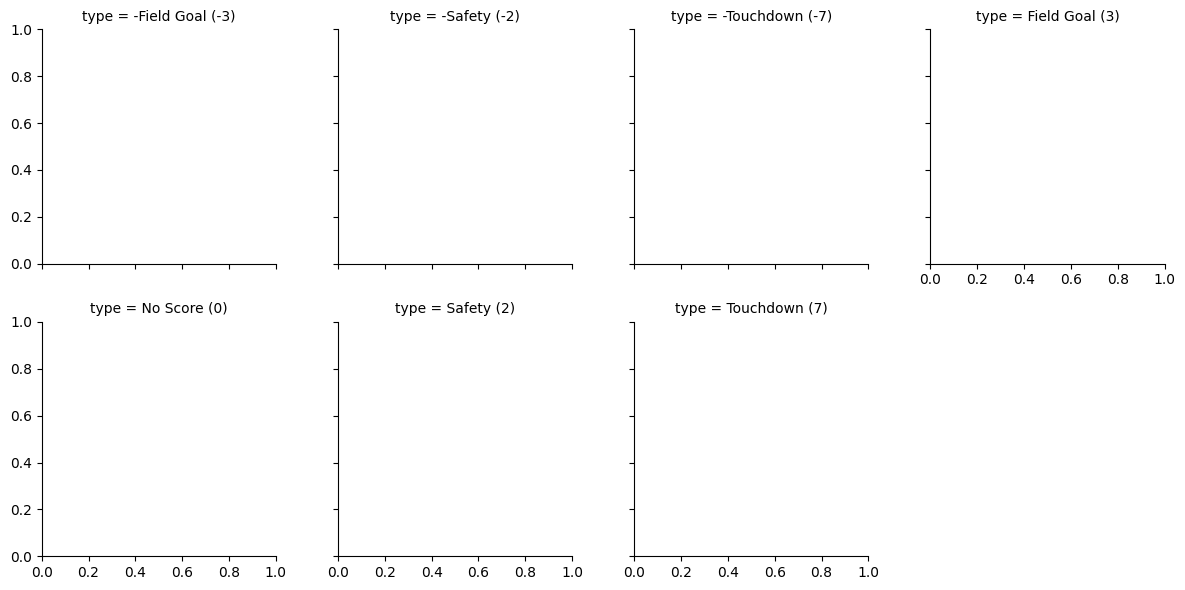

In [129]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
import seaborn as sns



# Annotation text data
ann_text = pd.DataFrame({
    'x': [0.25, 0.75],
    'y': [0.75, 0.25],
    'lab': ["More times\nthan expected", "Fewer times\nthan expected"]
})

# Reordering and recoding 'type'
type_order = ["Opp_Safety", "Opp_Field_Goal", "Opp_Touchdown", "No_Score", "Safety", "Field_Goal", "Touchdown"]
type_recode = {
    "Opp_Field_Goal": "-Field Goal (-3)",
    "Opp_Safety": "-Safety (-2)",
    "Opp_Touchdown": "-Touchdown (-7)",
    "Field_Goal": "Field Goal (3)",
    "No_Score": "No Score (0)",
    "Touchdown": "Touchdown (7)",
    "Safety": "Safety (2)"
}
summary_plot = summary.copy()
# summary_plot = summary_plot.loc[summary_plot['n_plays'] > 1]
summary_plot['type'] = summary_plot['type'].map(type_recode).astype('category')

# Creating the plot
g = sns.FacetGrid(data=summary_plot, col="type", col_wrap=4)
g.map(, "bin_pred_prob", "bin_actual_prob", s=summary_plot['n_plays'])
# g.map(sns.regplot, "bin_pred_prob", "bin_actual_prob", lowess=True, scatter=False)

# Adding annotations
for _, row in ann_text.iterrows():
    plt.text(row['x'], row['y'], row['lab'], size=2)

# Customizing the plot
g.set_axis_labels("Estimated next score probability", "Observed next score probability")
g.set(xlim=(0, 1), ylim=(0, 1))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('EPA Calibration Plot')
g.add_legend(title="Number of plays")

# Show plot
plt.show()
